In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import netCDF4
import xarray as xr
import hmp
from pathlib import Path
from mne.io import read_info
from mne import read_epochs
from hmpai.data import StageFinder
from hmpai.training import split_participants_custom
from hmpai.pytorch.utilities import set_global_seed
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [6]:
info_path = DATA_PATH / "prp2/processed/P05_T1-epo.fif"
positions = read_info(info_path)

epoch = read_epochs(info_path)
epoch.set_montage("standard_1005")
positions = epoch.info

Reading /workspace/data_local/prp2/processed/P05_T1-epo.fif ...


    Found the data of interest:
        t =    -200.00 ...    3200.00 ms
        0 CTF compensation matrices available
Adding metadata with 24 columns
767 matching events found
No baseline correction applied
0 projection items activated


### Calculate PCA weights over train set

In [ ]:
set_global_seed(42)
# data_paths = [DATA_PATH / "prp/data_t1_250hz_baseline.nc", DATA_PATH / "prp/data_t2_250hz_baseline.nc"]
data_paths = [DATA_PATH / "prp2/data_t1_250hz.nc", DATA_PATH / "prp2/data_t2_250hz.nc"]
splits = split_participants_custom(data_paths, 0.15)

conditions = ["short", "long"]
labels = {"short": ["negative", "t1_1", "t1_2", "t1_3"], "long": ["negative", "t1_1", "t1_2", "t1_3"]}

# for path, task in zip(data_paths, ["t1", "t2"]):
for path, task in zip(data_paths, ["t1", "t2"]):
    data = xr.load_dataset(path)
    data = data.sel(participant=splits[0])
    pca_finder = StageFinder(data, labels, conditions, n_comp=10)
    pca_finder.hmp_data_offset.pca_weights.to_netcdf(f"files/train_pca_{task}.nc")

#### Task 1

In [7]:
cpus = 8

epoched_data_path = DATA_PATH / "prp2/data_t1_250hz.nc"

conditions = ["lang"]
labels = {"lang": ["negative", "t1_1", "t1_2", "t1_3", "t1_4"]}
pca_weights = xr.load_dataarray("files/train_pca_t1.nc")

stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
    verbose=False,
    condition_variable="SOA",
    condition_method="equal",
    fit_args={"starting_points": 32},
    fits_to_load=["250hz_t1_long.nc"],
    n_comp=10,
    event_width=50,
    pca_weights=pca_weights,
)
stage_finder.fit_model()

Transforming epoched data to principal component (PC) space
Loading fitted HMP model for lang condition


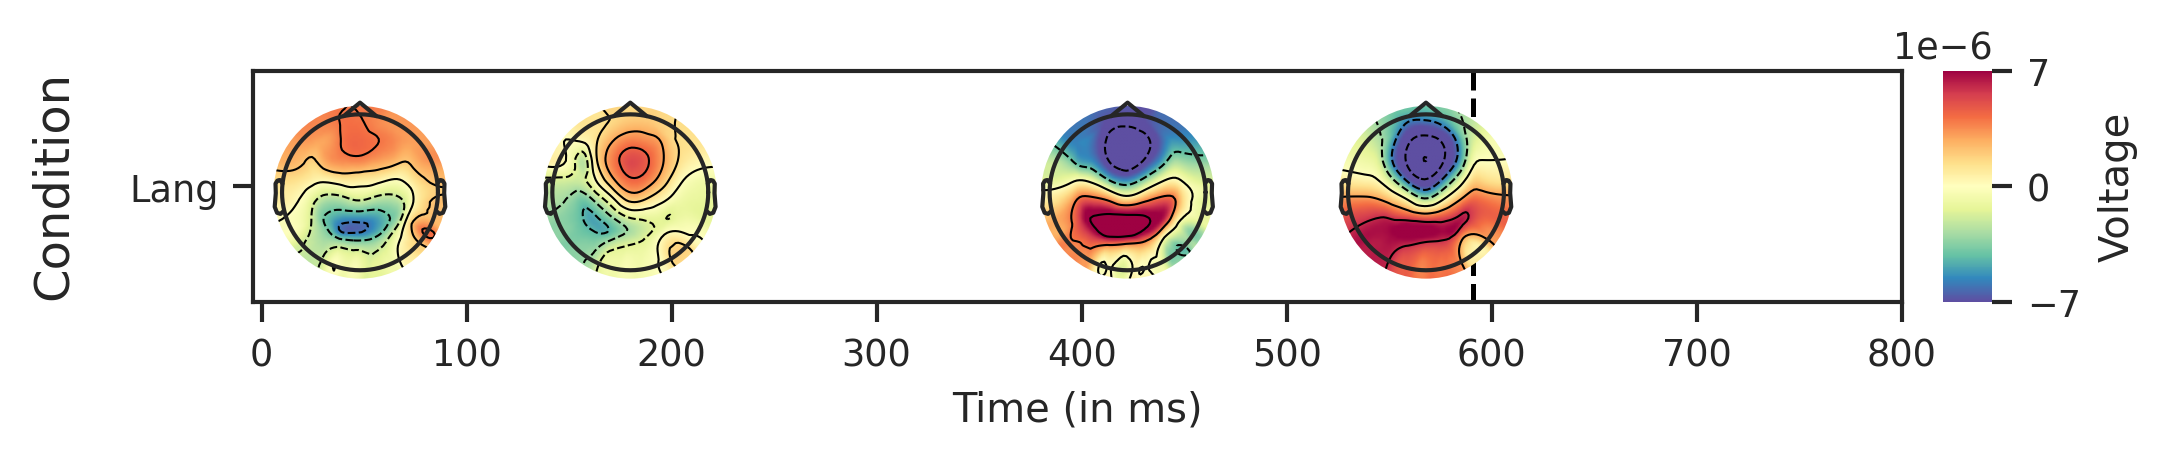

In [8]:
fig_t1, ax_t1 = stage_finder.visualize_model(positions, max_time=800, figsize=(7.09, 1), set_vlims=True)

In [6]:
fig_t1.savefig("img/hmp_fit_t1.svg")

In [8]:
# hmp.utils.save_fit(stage_finder.fits[0], "250hz_t1_short.nc")
hmp.utils.save_fit(stage_finder.fits[0], "250hz_t1_long.nc")

250hz_t1_long.nc saved


In [9]:
output_path = DATA_PATH / "prp2/stage_data_250hz_t1.nc"
stage_data = stage_finder.label_model(
    label_fn=stage_finder.__label_model_probabilistic__, probabilistic=True
)
stage_data.attrs["task"] = "prp2/t1"

Labeling dataset for lang condition
Processing participant P01b
Processing participant P02
Processing participant P03
Processing participant P04
Processing participant P05
Processing participant P06
Processing participant P07
Processing participant P08
Processing participant P09
Processing participant P10
Processing participant P11
Processing participant P12
Processing participant P13
Processing participant P14
Processing participant P15
Processing participant P16
Processing participant P17
Processing participant P18
Processing participant P19
Processing participant P20
Processing participant P21
Processing participant P22
Processing participant P23
Processing participant P24


In [11]:
stage_data = stage_data.rename_vars({"RT1korr": "rt"})
stage_data.to_netcdf(output_path)

#### Task 2

In [12]:
cpus = 8

epoched_data_path = DATA_PATH / "prp2/data_t2_250hz.nc"

conditions = ["lang"]
labels = {"lang": ["negative", "t2_1", "t2_2", "t2_3", "t2_4"]}

pca_weights = xr.load_dataarray("files/train_pca_t2.nc")

stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
    verbose=False,
    condition_variable="SOA",
    condition_method="equal",
    fit_args={"starting_points": 32},
    # extra_split=[("SOA", "equal", "lang")],
    fits_to_load=["250hz_t2_long.nc"],
    n_comp=10,
    event_width=50,
    pca_weights=pca_weights,
)
stage_finder.fit_model()

Transforming epoched data to principal component (PC) space
Loading fitted HMP model for lang condition


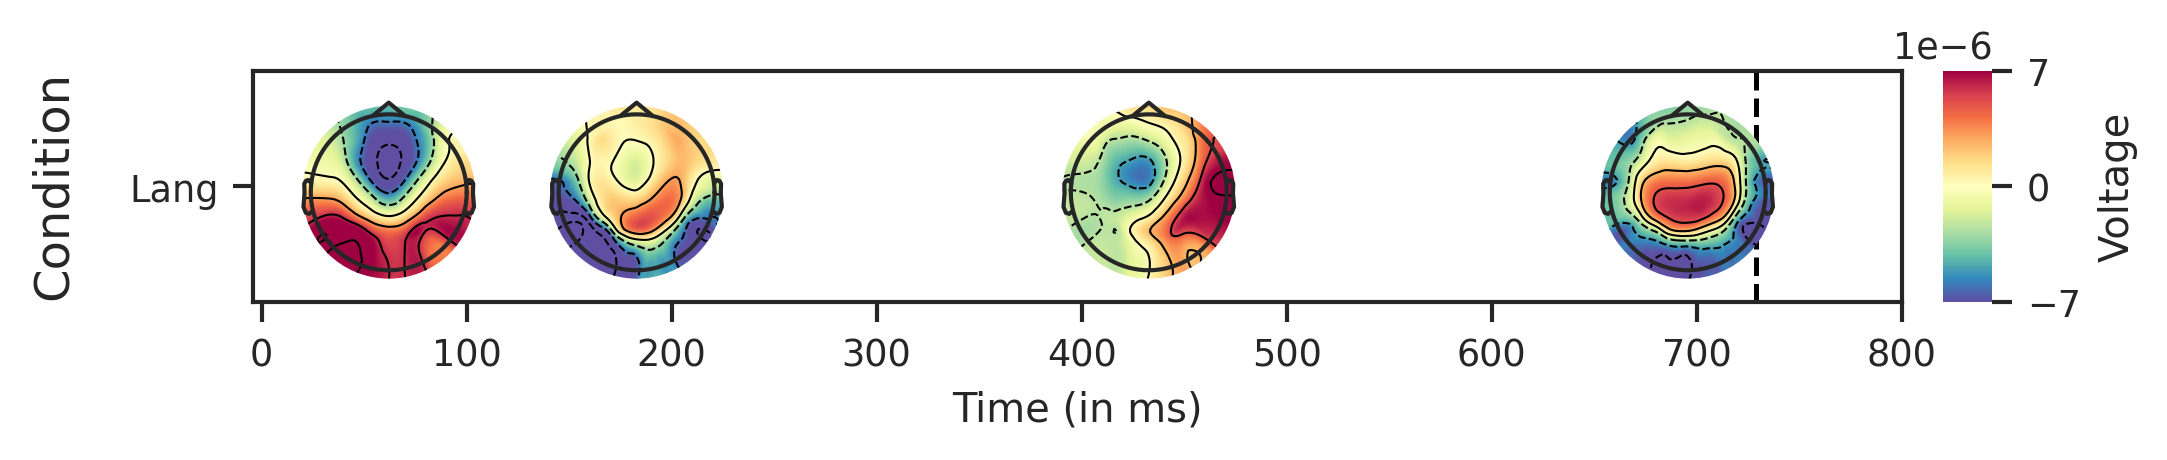

In [13]:
fig_t2, ax_t2 = stage_finder.visualize_model(positions, max_time=800, figsize=(7.09, 1), set_vlims=True)

In [14]:
fig_t2.savefig("img/hmp_fit_t2.svg")

In [15]:
hmp.utils.save_fit(stage_finder.fits[0], "250hz_t2_long.nc")

250hz_t2_long.nc saved


In [14]:
output_path = DATA_PATH / "prp2/stage_data_250hz_t2.nc"
stage_data = stage_finder.label_model(
    label_fn=stage_finder.__label_model_probabilistic__, probabilistic=True
)
stage_data.attrs["task"] = "prp2/t2"

Labeling dataset for lang condition
Processing participant P01b
Processing participant P02
Processing participant P03
Processing participant P04
Processing participant P05
Processing participant P06
Processing participant P07
Processing participant P08
Processing participant P09
Processing participant P10
Processing participant P11
Processing participant P12
Processing participant P13
Processing participant P14
Processing participant P15
Processing participant P16
Processing participant P17
Processing participant P18
Processing participant P19
Processing participant P20
Processing participant P21
Processing participant P22
Processing participant P23
Processing participant P24


In [15]:
stage_data = stage_data.rename_vars({"WortRTkorr": "rt"})
stage_data.to_netcdf(output_path)